# Shatterproofing
## Hedging Commodity Risk in America’s Boomtowns
This is the code which helps show the latent risk of commodity towns. 

In [419]:
# importing packages
import numpy as np
import pandas as pd
import linearmodels
import matplotlib.pyplot as plt
%matplotlib inline

### Cleaning
In the below cell, the data is brought in and cleaned for merging purposes. 
- Dates are set to pandas timestamps.
- Stacks are shifted from years and months to single time stamp values. 
- Percentage rates are set to decimals.
- People are set to thousands per year. 
- Identification columns are added for testing later. 
- Rolling means are calculated where applicable. 

In [508]:
d = 'csv_data/'
labor_force = pd.read_csv(d + 'civilian_labor_force.csv')
labor_force['DATE'] = pd.to_datetime(labor_force['DATE'])

df1 = pd.read_csv(d+ 'midland_employee_total_count.csv')
df1 = df1.set_index(['Year']).stack().reset_index()
df1 = df1[df1.level_1 != 'Annual']
date = df1['Year'].astype(str) + ' '+ df1['level_1']
df1['Date'] = pd.to_datetime(date)
df1['Employment'] = df1[[0]]
total_employees = df1.drop(columns=['Year', 'level_1', 0])

mining_employment =  pd.read_csv(d + 'midland_mining_employment_thousands_of_people_per_year.csv')
df2 = mining_employment.set_index(['Year']).stack().reset_index()
df2 = df2[df2.level_1 != 'Annual']
date = df2['Year'].astype(str) + ' '+ df2['level_1']
df2['Date'] = pd.to_datetime(date)
df2['MineEmploy'] = df2[[0]]
df2['MineEmploy'] *= 1000
mining_employment = df2.drop(columns=['Year', 'level_1', 0])

unemployment_rate = pd.read_csv(d +'unemployment_rate_midland_tx_by_year.csv')
df3 = unemployment_rate.set_index(['Year']).stack().reset_index()
df3 = df3[df3.level_1 != 'Annual']
date = df3['Year'].astype(str) + ' '+ df3['level_1']
df3['Date'] = pd.to_datetime(date)
df3.replace('x', '0', inplace=True)
df3.replace('   ', '3.71', inplace=True)
df3['Rate'] = df3[[0]]
df3['Rate'] = df3.Rate.astype(float)
df3['Rate'] /= 100
df3['Region'] = "Midland"
unemployment_rate = df3.drop(columns=['Year', 'level_1', 0])

df4 = pd.read_csv(d +'unemployment_rate.csv')
df4['NationalRate'] = df4.UNRATE.astype(float)/100
df4['Date'] =pd.to_datetime(df4['DATE'])
df4['Region'] = "National"
unemployment_rate_nat = df4.drop(columns=['DATE', 'UNRATE'])


df5 = pd.read_csv(d + 'WTI_Oil.csv')
df5['Date'] = pd.to_datetime(df5['Date'])
df5['RollingMean'] = df5['Price'].rolling(10).mean()
df5.sort_values("Date", inplace=True)
df5['Date'] = pd.to_datetime(df5.Date) + pd.offsets.MonthBegin(-1)
oil_price = df5.groupby("Date").first()

Sample of the national unemploymnet rate data.

In [509]:
unemployment_rate_nat.head()

,NationalRate,Date,Region
0,0.034,1948-01-01,National
1,0.038,1948-02-01,National
2,0.040,1948-03-01,National
3,0.039,1948-04-01,National
4,0.035,1948-05-01,National


Sample of the total persons employed in Midland data.

In [510]:
total_employees.head()

,Date,Employment
0,2008-01-01,66749.0
1,2008-02-01,67317.0
2,2008-03-01,67942.0
3,2008-04-01,68270.0
4,2008-05-01,68911.0


Sample of the mining persons employed in Midland data.

In [511]:
mining_employment.head()

,Date,MineEmploy
0,2009-01-01,16800.0
1,2009-02-01,16200.0
2,2009-03-01,15700.0
3,2009-04-01,15100.0
4,2009-05-01,14700.0


Sample of the local unemploymnet rate data.

In [512]:
unemployment_rate.head()

,Date,Rate,Region
0,2009-01-01,0.000,Midland
1,2009-02-01,0.040,Midland
2,2009-03-01,0.044,Midland
3,2009-04-01,0.045,Midland
4,2009-05-01,0.057,Midland


Sample of the Oil Price Data.

In [514]:
oil_price.head()

,Price,Open,High,Low,Vol.,Change %,RollingMean
Date,,,,,,,
2010-05-01,75.65,75.89,77.00,74.75,475.85K,-0.94%,70.803
2010-06-01,72.86,71.94,73.93,71.68,391.03K,0.39%,73.811
2010-07-01,72.14,72.67,73.38,71.62,256.17K,-1.11%,75.149
2010-08-01,81.34,78.95,81.77,78.83,306.10K,3.03%,79.995
2010-09-01,75.02,73.91,75.14,73.11,340.17K,1.50%,75.366


The below cell merges all of the data frames together.

In [515]:
mp = oil_price.merge(unemployment_rate, on='Date').merge(mining_employment, on='Date').merge(total_employees, on='Date').merge(labor_force, left_on='Date', right_on='DATE').merge(unemployment_rate_nat, left_on='Date', right_on='Date').sort_values('Date').sort_values('Date')
# sample
mp.head()

,Date,Price,Open,High,Low,Vol.,Change %,RollingMean,Rate,Region_x,MineEmploy,Employment,DATE,TXMIDL9LFN,NationalRate,Region_y
0,2010-05-01,75.65,75.89,77.00,74.75,475.85K,-0.94%,70.803,0.058,Midland,15600.0,67377.0,2010-05-01,70749,0.096,National
1,2010-06-01,72.86,71.94,73.93,71.68,391.03K,0.39%,73.811,0.062,Midland,16000.0,67650.0,2010-06-01,71271,0.094,National
2,2010-07-01,72.14,72.67,73.38,71.62,256.17K,-1.11%,75.149,0.060,Midland,16200.0,67436.0,2010-07-01,72057,0.094,National
3,2010-08-01,81.34,78.95,81.77,78.83,306.10K,3.03%,79.995,0.058,Midland,16300.0,67773.0,2010-08-01,72179,0.095,National
4,2010-09-01,75.02,73.91,75.14,73.11,340.17K,1.50%,75.366,0.055,Midland,16400.0,68297.0,2010-09-01,72494,0.095,National


In [516]:
# for saving images
img = 'images/'
blue = 'tab:blue'

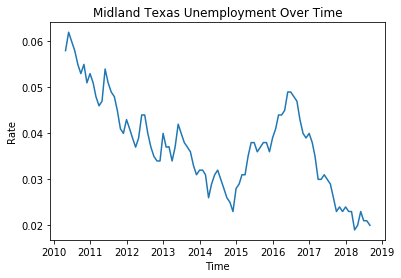

In [517]:
# employment rate over time
plt.plot(mp.Date, mp.Rate, color=blue)
plt.title('Midland Texas Unemployment Over Time')
plt.xlabel('Time')
plt.ylabel('Rate');
plt.savefig(img + 'unemployment_over_time.png')

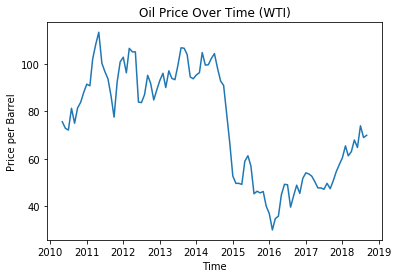

In [518]:
# Oil price over time
plt.plot(mp.Date, mp.Price, color=blue)
plt.title('Oil Price Over Time (WTI)')
plt.xlabel('Time')
plt.ylabel('Price per Barrel');
plt.savefig(img + 'oil_price_over_time.png');

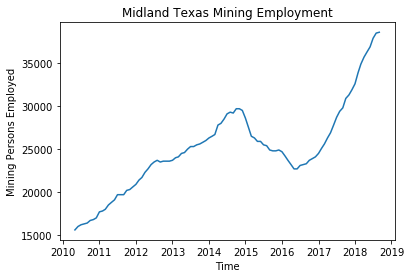

In [519]:
plt.plot(mp.Date, mp.MineEmploy, color=blue)
plt.title('Midland Texas Mining Employment')
plt.xlabel('Time')
plt.ylabel('Mining Persons Employed');
plt.savefig(img + 'mining_employment_over_time.png');

In [520]:
# maxes and mins during the drawdown for employment and mining employment
max(mp.Employment[20:60]), min(mp.Employment[20:60]), max(mp.MineEmploy[20:60]), min(mp.MineEmploy[20:60])

(94855.0, 75802.0, 29700.0, 20900.0)

In [521]:
# max and min prices
max(mp.Price[20:60]), min(mp.Price[20:60])

(106.94, 49.14)

In [522]:
# crash recovery, pre crash, crash
cr = mp[mp.Date >= '2015-06-01']
pc = mp[mp.Date < '2014-06-01']
c = mp.query("Date < '2015-06-01' and Date > '2014-06-01'")

In [523]:
# detrending 
price_dt = mp.Price.shift(1) - mp.Price
employ_dt = mp.Employment.shift(1) - mp.Employment
mine_dt = cr.MineEmploy.shift(1) - cr.MineEmploy

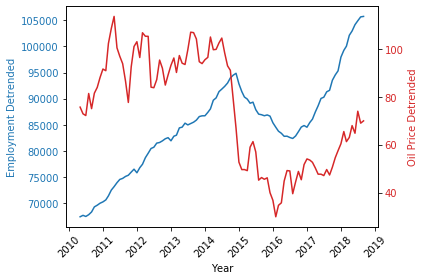

In [524]:
# employment and oil price
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(mp.Date,  mp.Employment, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(mp.Date, mp.Price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

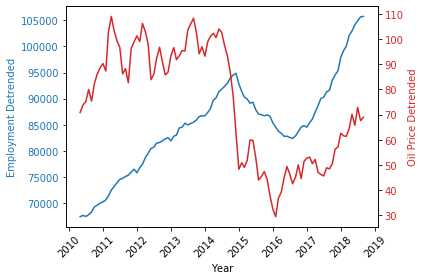

In [525]:
# employment and oil price
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(mp.Date,  mp.Employment, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(mp.Date, mp.RollingMean, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

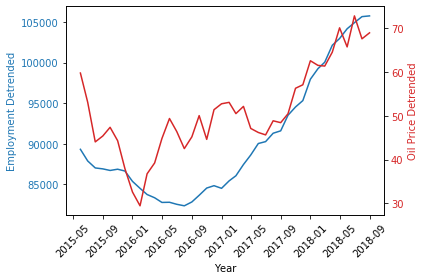

In [526]:
# employment and oil price
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(cr.Date,  cr.Employment, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(cr.Date, cr.RollingMean, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

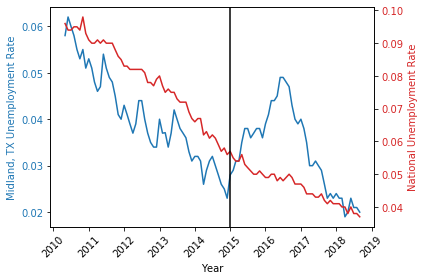

In [498]:
# employment rate and national rate
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Midland, TX Unemployment Rate', color=color)
ax1.plot(mp.Date, mp.Rate, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('National Unemployment Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(mp.Date, mp.NationalRate, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.axvline(x="2015", color='black', label='Oil hits $53 a barrel, from $115 6 months earlier')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(img + 'national_umeployment_versus_midland.png')
plt.show()

In [483]:
# sample correlation between employment and price
sample_corr = np.corrcoef(cr.Employment, cr.Price)[0][1]
sample_corr

0.8399348923957319

In [484]:
array_of_samples = []
for i in range(10000):
    monte_carlo_data = np.zeros_like(mp.Price)
    sim_returns = np.random.normal(1, np.std((mp.Price/mp.Price.shift(-1))[1:] - 1), len(mp.Price))
    monte_carlo_data[0] = mp.Price.values[0]
    random_crash_day = int(np.random.uniform(1, len(mp.Price)))
    for i in range(1, len(mp.Price)):
        if i == random_crash_day:
            crash_multiplier = np.random.uniform(.4, .85)
            monte_carlo_data[i] = monte_carlo_data[i - 1] * crash_multiplier
        else:
            monte_carlo_data[i] = monte_carlo_data[i - 1] * sim_returns[i]
    array_of_samples.append(np.array(monte_carlo_data))
corrs = np.array([])
for arr in array_of_samples:
    corr = np.corrcoef(arr, mp.MineEmploy)[0][1]
    corrs = np.append(corrs, corr)
    
#  base case compared to observed
sample_corr = np.corrcoef(c.Price[1:], c.MineEmploy.shift(1)[1:])[0][1]
np.sum(corrs > sample_corr)/len(corrs)

0.0497

In [486]:
# difference in difference regression, pre cleaning 
nat_rate = unemployment_rate_nat.rename(columns={"NationalRate":"Rate"})
rate_regression = unemployment_rate.append(nat_rate[nat_rate.Date > "2010-06-01"], sort=True)
rate_regression["Treatment"] = rate_regression.Region == 'Midland'
rate_regression["Treatment"] = rate_regression["Treatment"].astype(int)
rate_regression["Post"] = rate_regression.Date >= "2015" 
rate_regression["Post"] = rate_regression["Post"].astype(int)
rate_regression["PostTreatment"] = rate_regression["Treatment"] * rate_regression["Post"]
rate_regression["Constant"] = 1
# dropping around 2015-01-01
rate_regression = rate_regression[rate_regression.Date <= "2018"]
rate_regression = rate_regression[rate_regression.Date >= "2012"]
employ_regression.sort_values("Date", inplace=True)

In [494]:
# the regression itself
import statsmodels.api as sm
X_rate = rate_regression[["Treatment", "Post", "PostTreatment", "Constant"]]
model_rate = sm.OLS(rate_regression.Rate, X_rate)
results_rate = model_rate.fit()
print(results_rate.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     240.9
Date:                Mon, 11 May 2020   Prob (F-statistic):           1.75e-55
Time:                        00:04:41   Log-Likelihood:                 525.82
No. Observations:                 146   AIC:                            -1044.
Df Residuals:                     142   BIC:                            -1032.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Treatment        -0.0371      0.002    -23.537

In [495]:
# html rendering
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

stargazer = Stargazer([results])
stargazer.render_html()

'<table style="text-align:center"><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="1"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td></tr><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Constant</td><td>0.072<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.001)</td></tr><tr><td style="text-align:left">Post</td><td>-0.024<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td></tr><tr><td style="text-align:left">PostTreatment</td><td>0.025<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td></tr><tr><td style="text-align:left">Treatment</td><td>-0.037<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td></tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">

In [496]:
# a less meaningful regression
employ_regression = mining_employment[["Date", "MineEmploy"]]
employ_regression["MineEmploy"] = (employ_regression["MineEmploy"] - np.mean(employ_regression["MineEmploy"]))/np.std(employ_regression["MineEmploy"])
employ_regression.rename(columns={"MineEmploy":"Employment"}, inplace=True)
employ_regression["Type"] = "Mining"
add_employment = total_employees[["Date", "Employment"]]
for_subtracting = employ_regression.merge(add_employment, on="Date", how='inner')
employees_ex_mining = for_subtracting.Employment_y - for_subtracting.Employment_x
add_employment = for_subtracting[["Date"]].copy()
add_employment["Employment"] = (employees_ex_mining - np.mean(employees_ex_mining))/np.std(employees_ex_mining)
add_employment["Type"] = "All"
employ_regression = employ_regression.append(add_employment)
employ_regression["Treatment"] = employ_regression.Type == 'Mining'
employ_regression["Treatment"] = employ_regression["Treatment"].astype(int)
employ_regression["Post"] = employ_regression.Date >= "2015" 
employ_regression["Post"] = employ_regression["Post"].astype(int)
employ_regression["PostTreatment"] = employ_regression["Treatment"] * employ_regression["Post"]
employ_regression["Constant"] = 1
employ_regression = employ_regression[employ_regression.Date <= "2018"]
employ_regression = employ_regression[employ_regression.Date >= "2012"]
employ_regression.sort_values("Date", inplace=True)

In [497]:
# other model
X_employ = employ_regression[["Treatment", "Post", "PostTreatment", "Constant"]]
model_employ = sm.OLS(employ_regression.Employment, X_employ)
results_employ = model_employ.fit()
print(results_employ.summary())

                            OLS Regression Results                            
Dep. Variable:             Employment   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     5.085
Date:                Mon, 11 May 2020   Prob (F-statistic):            0.00225
Time:                        00:04:54   Log-Likelihood:                -75.808
No. Observations:                 146   AIC:                             159.6
Df Residuals:                     142   BIC:                             171.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Treatment        -0.1384      0.097     -1.424